In [ ]:
# Neural Network for Images (67103) - Exercise 2 Autoencoders
# Submission by: Amit Halbreich

# Neural Network for Images (67103) - Exercise 2 Autoencoders
# Submission by: Amit Halbreich

In [1]:
# Weights & Biases

!pip install wandb -qU

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.8/198.8 kB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 16.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.8 MB/s eta 0:00:00


In [18]:
import wandb
wandb.login()

# wandb.init(project="ex2-amithalbreich",
#   config={
#   "learning_rate": 0.003,
#   "architecture": "CNN",
#   "dataset": "MNIST",
#   "epochs": 15,
#   }
# )

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

Autoencoders
======

In [101]:
%matplotlib inline
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

Parameter Settings
-------------------


In [102]:
latent_dims = 15
num_epochs = 5
batch_size = 128
capacity = 128
learning_rate = 1e-3
use_gpu = True

MNIST Data Loading
-------------------

MNIST images show digits from 0-9 in 28x28 grayscale images. We normalize and center them around 0, which gives a slight performance boost during training.
We create both a training set and a test set.

In [103]:

import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

img_transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = MNIST(root='./data/MNIST', download=True, train=True, transform=img_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = MNIST(root='./data/MNIST', download=True, train=False, transform=img_transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


Autoencoder Definition
-----------------------

In [104]:
class Encoder(nn.Module):
    def __init__(self, latent_dims):
        super(Encoder, self).__init__()
        c = capacity
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=c, kernel_size=4, stride=2, padding=1) # out: c x 14 x 14
        self.conv2 = nn.Conv2d(in_channels=c, out_channels=c*2, kernel_size=4, stride=2, padding=1) # out: c x 7 x 7
        self.fc = nn.Linear(in_features=c*2*7*7, out_features=latent_dims)
            
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        c = capacity
        self.fc = nn.Linear(in_features=latent_dims, out_features=c*2*7*7)
        self.conv2 = nn.ConvTranspose2d(in_channels=c*2, out_channels=c, kernel_size=4, stride=2, padding=1)
        self.conv1 = nn.ConvTranspose2d(in_channels=c, out_channels=1, kernel_size=4, stride=2, padding=1)
        self.sigmoid = nn.Sigmoid()
            
    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), capacity*2, 7, 7)
        x = F.relu(self.conv2(x))
        x = self.sigmoid(self.conv1(x))
        return x
    
class Autoencoder(nn.Module):
    def __init__(self,latent_dims):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(latent_dims)
        self.decoder = Decoder(latent_dims)
    
    def forward(self, x):
        latent = self.encoder(x)
        x_recon = self.decoder(latent)
        return x_recon
    
autoencoder = Autoencoder(latent_dims)


device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
autoencoder = autoencoder.to(device)
print(device)

num_params = sum(p.numel() for p in autoencoder.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)
# wandb.log({"AutoEncoder Parameters": num_params})

cuda:0
Number of parameters: 1442064


In [105]:
def train_autoencoder(autoencoder, train_dataloader, test_dataloader, optimizer, num_epochs, device):
    train_loss_avg = []
    test_loss_avg = []

    wandb.init(project="ex2-amithalbreich2",
      config={
      "learning_rate": 0.003,
      "architecture": "CNN",
      "dataset": "MNIST",
      "epochs": 10,
      }
    )

    num_params = sum(p.numel() for p in autoencoder.parameters() if p.requires_grad)
    print('AutoEncoder Parameters: %d' % num_params)
    wandb.log({"AutoEncoder Parameters": num_params})
    # wandb.log({"dims": latent_dims})

    for epoch in range(num_epochs):
        # set to training mode
        autoencoder.train()
        train_loss_avg.append(0)
        test_loss_avg.append(0)
        num_batches_train = 0
        num_batches_test = 0
        for image_batch, _ in train_dataloader:

            image_batch = image_batch.to(device)

            # autoencoder reconstruction
            image_batch_recon = autoencoder(image_batch)

            # reconstruction error
            loss = F.mse_loss(image_batch_recon, image_batch)

            # backpropagation
            optimizer.zero_grad()
            loss.backward()

            # one step of the optmizer (using the gradients from backpropagation)
            optimizer.step()

            train_loss_avg[-1] += loss.item()
            num_batches_train += 1
        train_loss_avg[-1] /= num_batches_train
        autoencoder.eval()
        
        for image_batch, _ in test_dataloader:
            
            with torch.no_grad():

                image_batch = image_batch.to(device)

                # autoencoder reconstruction
                image_batch_recon = autoencoder(image_batch)

                # reconstruction error
                loss = F.mse_loss(image_batch_recon, image_batch)

                test_loss_avg[-1] += loss.item()
                num_batches_test += 1
        test_loss_avg[-1] /= num_batches_test
        autoencoder.train()
        print('Epoch [%d / %d] average reconstruction error on Train dataset: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))
        print('Epoch [%d / %d] average reconstruction error on Test dataset: %f' % (epoch+1, num_epochs, test_loss_avg[-1]))
        wandb.log({"Train Loss": train_loss_avg[-1],"Test Loss": test_loss_avg[-1], "Epoch": epoch + 1})

    return train_loss_avg,test_loss_avg, autoencoder

def test_autoencoder(autoencoder, test_dataloader, device):
    # set to evaluation mode
    autoencoder.eval()

    test_loss_avg = []

    print('Training on test dataset ...')
    for epoch in range(num_epochs):
        test_loss_avg.append(0)
        num_batches = 0
        for image_batch, _ in test_dataloader:
            
            with torch.no_grad():

                image_batch = image_batch.to(device)

                # autoencoder reconstruction
                image_batch_recon = autoencoder(image_batch)

                # reconstruction error
                loss = F.mse_loss(image_batch_recon, image_batch)

                test_loss_avg[-1] += loss.item()
                num_batches += 1
            
        test_loss_avg[-1] /= num_batches
        print('Epoch [%d / %d] average reconstruction error on test dataset: %f' % (epoch+1, num_epochs, test_loss_avg[-1]))
        wandb.log({"Test Loss": test_loss_avg[-1], "Epoch": epoch}) 

    return test_loss_avg


Train Autoencoder
--------

In [106]:
from torch.optim import AdamW

optimizer = AdamW(autoencoder.parameters(), lr=learning_rate, weight_decay=1e-5)
train_loss_avg, test_loss_avg, autoencoder = train_autoencoder(autoencoder, train_dataloader, test_dataloader, optimizer, num_epochs, device)

Autoencoder Parameters,▁
Epoch num,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Test Accuracy Full Network,▁▁▂▃▃▃▃▄▄▅▅▅▆▇▇▇▇███████████████████████
Test Loss Full Network,████▇▇▇▆▅▅▄▄▃▃▂▂▁▁▁▁▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▄
Train Loss Full Network,████▇▇▇▇▆▆▅▅▄▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
dims,▁
Autoencoder Parameters,718329
Epoch num,50
Test Accuracy Full Network,74.5
Test Loss Full Network,1.56071
Train Loss Full Network,0.00081


AutoEncoder Parameters: 1442064
Epoch [1 / 5] average reconstruction error on Train dataset: 0.030952
Epoch [1 / 5] average reconstruction error on Test dataset: 0.013111
Epoch [2 / 5] average reconstruction error on Train dataset: 0.011869
Epoch [2 / 5] average reconstruction error on Test dataset: 0.010656
Epoch [3 / 5] average reconstruction error on Train dataset: 0.010253
Epoch [3 / 5] average reconstruction error on Test dataset: 0.009739
Epoch [4 / 5] average reconstruction error on Train dataset: 0.009399
Epoch [4 / 5] average reconstruction error on Test dataset: 0.009175
Epoch [5 / 5] average reconstruction error on Train dataset: 0.008867
Epoch [5 / 5] average reconstruction error on Test dataset: 0.008683


Evaluate on the Test Set
-------------------------

Visualize Reconstructions
--------------------------

Plot Training Curve
--------------------

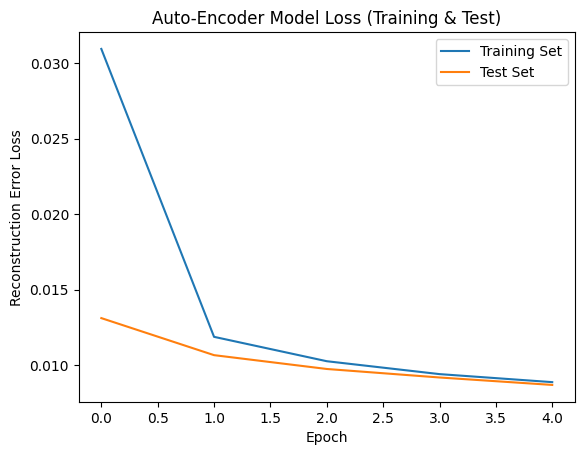

In [107]:
import matplotlib.pyplot as plt
plt.ion()

# fig = plt.figure()
# plt.plot(train_loss_avg)
# plt.xlabel('Epochs')
# plt.ylabel('Reconstruction error')
# plt.show()

# Plot the training and validation loss
plt.plot(train_loss_avg, label='Training Set')
plt.plot(test_loss_avg, label='Test Set')
plt.title('Auto-Encoder Model Loss (Training & Test)')
plt.ylabel('Reconstruction Error Loss')
plt.xlabel('Epoch')
plt.legend(['Training Set', 'Test Set'], loc='upper right')
plt.show()

Original images


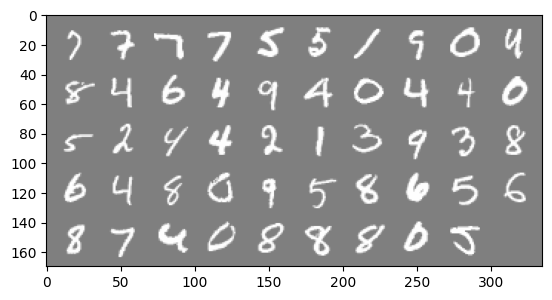

Autoencoder reconstruction:


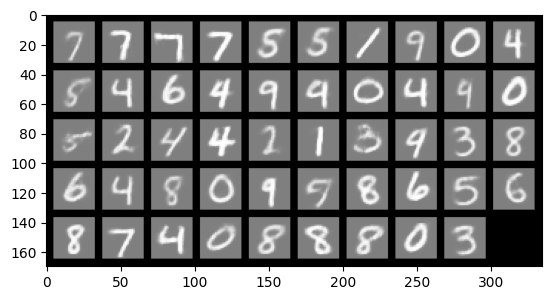

In [47]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

autoencoder.eval()

# This function takes as an input the images to reconstruct
# and the name of the model with which the reconstructions
# are performed
def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def visualise_output(images, model):

    with torch.no_grad():

        images = images.to(device)
        images = model(images)
        images = images.cpu()
        images = to_img(images)
        np_imagegrid = torchvision.utils.make_grid(images[1:50], 10, 5).numpy()
        plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
        plt.show()

# Get a batch of test images
images, labels = next(iter(test_dataloader))

# First visualise the original images
print('Original images')
show_image(torchvision.utils.make_grid(images[1:50],10,5))
plt.show()

# Reconstruct and visualise the images using the autoencoder
print('Autoencoder reconstruction:')
visualise_output(images, autoencoder)

Interpolate in Latent Space
----------------------------

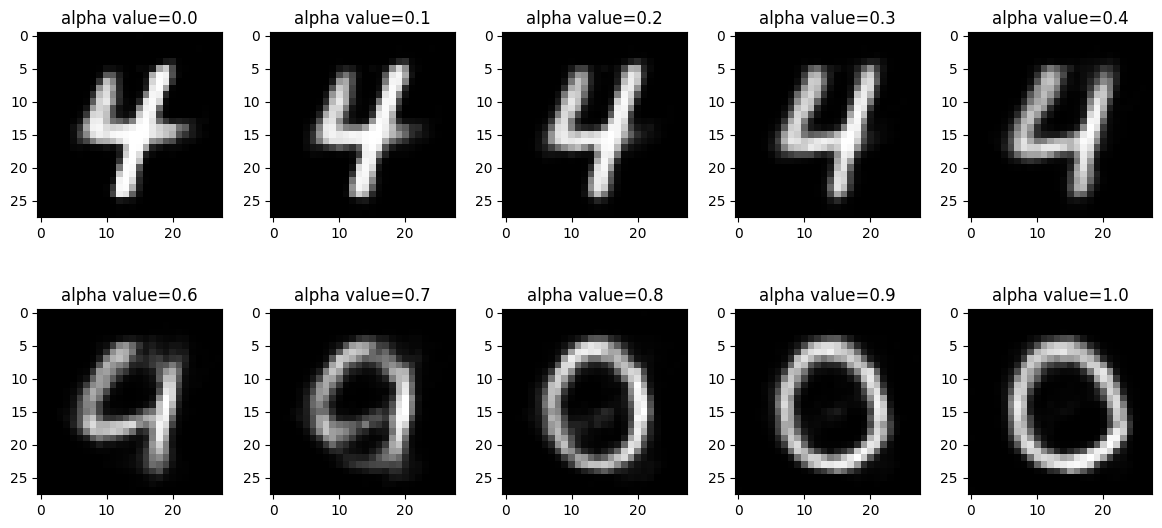

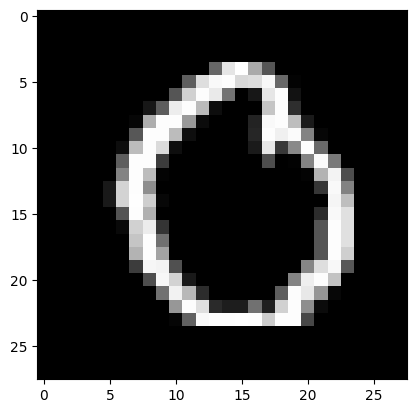

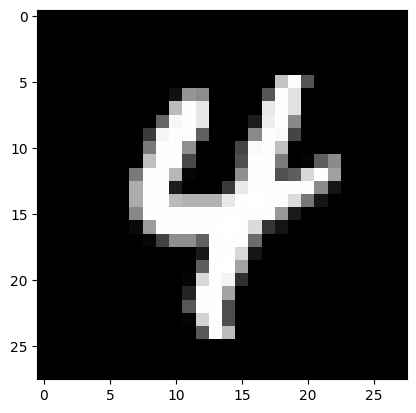

In [62]:
autoencoder.eval()

def interpolation(alpha, model, img1, img2):
    
    with torch.no_grad():

        # latent vector of first image
        img1 = img1.to(device)
        latent_1 = model.encoder(img1)

        # latent vector of second image
        img2 = img2.to(device)
        latent_2 = model.encoder(img2)

        # interpolation of the two latent vectors
        inter_latent = alpha * latent_1 + (1- alpha) * latent_2

        # reconstruct interpolated image
        inter_image = model.decoder(inter_latent)
        inter_image = inter_image.cpu()
    
    return inter_image
    
# sort part of test set by digit
digits = [[] for _ in range(10)]
for img_batch, label_batch in test_dataloader:
    for i in range(img_batch.size(0)):
        digits[label_batch[i]].append(img_batch[i:i+1])
    if sum(len(d) for d in digits) >= 1000:
        break;

# interpolation alphas
alpha_range=np.linspace(0,1,10)

fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

for ind,l in enumerate(alpha_range):
    inter_image=interpolation(float(l), autoencoder, digits[0][0], digits[4][0])
   
    inter_image = to_img(inter_image)
    
    image = inter_image.numpy()
   
    axs[ind].imshow(image[0,0,:,:], cmap='gray')
    axs[ind].set_title('alpha value='+str(round(l,1)))

plt.show() 


def show_single_img(index, digits, image):
    fig = plt.figure()
    image = digits[index][0].cpu()
    image = to_img(image) 
    image = image.numpy()
    plt.imshow(image[0,0,:,:], cmap='gray')
    plt.show()

show_single_img(0,digits, image)
show_single_img(4,digits, image)

Random Latent Vector (Autoencoder as Generator)
-------------------------------------------------

Here latent vectors are sampled randomly from a multivariate Normal distribution fit to the distribution of data latent vectors.

Due to sampling from a fitted Normal distribution, we are in the same region of latent space as the encoded data, but even so, generating new digits is hit-or-miss: many latent vectors decode to something that does not look like a digit. This means that the manifold of latent vectors that do decode to valid digits is sparse in latent space. With higher-dimensional latent spaces, the manifold gets sparser. Compare this to Variational Autoencoders that can more consistently generate valid digits from random samples.

In [ ]:
import numpy as np
import random
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torch.optim import AdamW
import matplotlib.pyplot as plt

# Function to calculate correlation matrix
def calculate_correlation_matrix(model, test_dataloader, latent_code_dims, device, num_samples):
    model.eval()
    num_pairs = 0
    corr_matrix = np.zeros((latent_code_dims, latent_code_dims))
    with torch.no_grad():
        for i, (image_batch, _) in enumerate(test_dataloader):
            if i >= num_samples:  # Limit to a subset of data
                break
            image_batch = image_batch.to(device)
            latent_codes = model.encoder(image_batch)
            latent_codes = latent_codes.cpu().numpy()
            for i in range(latent_code_dims):
                for j in range(i+1, latent_code_dims):
                    corr_matrix[i][j] += np.corrcoef(latent_codes[:, i], latent_codes[:, j], rowvar=False)[0][1]
                    num_pairs += 1
    corr_matrix /= num_pairs
    corr_matrix = corr_matrix + np.transpose(corr_matrix)
    np.fill_diagonal(corr_matrix, 1.0)
    return corr_matrix

# Function to calculate correlation matrix
def calculate_correlation_matrix2(model, test_dataloader, latent_code_dims, device, num_samples):
    model.eval()
    num_pairs = 0
    corr_matrix = np.zeros((latent_code_dims, latent_code_dims))
    with torch.no_grad():
        for i, (image_batch, _) in enumerate(test_dataloader):
            if i >= num_samples:  # Limit to a subset of data
                break
            image_batch = image_batch.to(device)
            latent_codes = model.encoder(image_batch)
            latent_codes = latent_codes.cpu().numpy()
            corr_matrix = np.corrcoef(latent_codes, latent_codes)
    # corr_matrix /= num_pairs
    # corr_matrix = corr_matrix + np.transpose(corr_matrix)
    np.fill_diagonal(corr_matrix, 1.0)
    return corr_matrix


# Function to calculate overall correlation
def calculate_overall_correlation(corr_matrix):
    num_pairs = corr_matrix.shape[0] * (corr_matrix.shape[0] - 1)
    overall_corr = np.sum(abs(corr_matrix)) / num_pairs
    return overall_corr

# Function to train autoencoder without calculating correlation matrix
def only_train_autoencoder(autoencoder, train_dataloader, optimizer, num_epochs, device):
    train_loss_avg = []
    for epoch in range(num_epochs):
        # set to training mode
        autoencoder.train()
        train_loss_avg.append(0)
        num_batches_train = 0
        for image_batch, _ in train_dataloader:
            image_batch = image_batch.to(device)

            # autoencoder reconstruction
            image_batch_recon = autoencoder(image_batch)

            # reconstruction error
            loss = F.mse_loss(image_batch_recon, image_batch)

            # backpropagation
            optimizer.zero_grad()
            loss.backward()

            # one step of the optmizer (using the gradients from backpropagation)
            optimizer.step()

            train_loss_avg[-1] += loss.item()
            num_batches_train += 1
        train_loss_avg[-1] /= num_batches_train
        autoencoder.train()
        print('Epoch [%d / %d] average reconstruction error on Train dataset: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))
        wandb.log({"Train Loss": train_loss_avg[-1],"Epoch": epoch + 1})

    return train_loss_avg

# test_dataset = MNIST(root='./data/MNIST', download=True, train=False, transform=img_transform)
# test_size = len(test_dataset)
# test_indices = random.sample(range(test_size), 10000)  # select a random subset of 10000 samples
# test_subset = torch.utils.data.Subset(test_dataset, test_indices)
# test_dataloader = DataLoader(test_subset, batch_size=batch_size, shuffle=True)

def plot_correlation_graph(dims):
    correlation_results = []
    for d in dims:
        print('dims=%f' % d)
        autoencoder = Autoencoder(d)
        optimizer = AdamW(autoencoder.parameters(), lr=learning_rate, weight_decay=1e-5)

        device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
        autoencoder = autoencoder.to(device)
        print(device)

        num_params = sum(p.numel() for p in autoencoder.parameters() if p.requires_grad)
        print('Number of parameters: %d' % num_params)
        # wandb.log({"AutoEncoder Parameters": num_params})
       # Specify the number of samples from the test data set to use for correlation calculation
        num_samples = 10000  # Change this to the desired number of samples

        # Train autoencoder
        train_loss_avg,test_loss_avg = train_autoencoder(autoencoder, train_dataloader, test_dataloader, optimizer, num_epochs, device)

        plt.ion()
        fig = plt.figure()
        # Plot the training and validation loss
        plt.plot(train_loss_avg, label='Training Set')
        plt.plot(test_loss_avg, label='Test Set')
        plt.title('Auto-Encoder Model Loss (Training & Test)')
        plt.ylabel('Reconstruction Error Loss')
        plt.xlabel('Epoch')
        plt.legend(['Training Set', 'Test Set'], loc='upper right')
        plt.show()

        # Calculate correlation matrix using a subset of data from the test data set
        corr_matrix = calculate_correlation_matrix(autoencoder, test_dataloader, d, device, num_samples)

        # Calculate overall correlation
        overall_corr = calculate_overall_correlation(corr_matrix)
        print('Overall Correlation: %.4f' % overall_corr)
        correlation_results.append(overall_corr)
        wandb.log({"Latent Code Dims" : d, "Overall Correlation": overall_corr})
    # Plot Overall Correlation vs. Latent Code Dimension
    plt.plot(dims, correlation_results)
    plt.xlabel('Latent Code Dimension')
    plt.ylabel('Overall Correlation')
    plt.title('Overall Correlation vs. Latent Code Dimension')
    plt.show()


dims=3.000000
cuda:0
Number of parameters: 1140996


Autoencoder Parameters,▁
Epoch num,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Test Accuracy Full Network,▁▁▂▂▃▃▃▄▅▅▅▅▆▆▆▇▇▇▇█████████████████████
Test Loss Full Network,▆▅▄▄▃▂▂▂▂▂▂▂▁▁▁▁▁▂▂▂▃▃▄▄▆▆▆▆▇▆▇▇▇▇▇▇████
Train Loss Full Network,█▇▇▆▅▅▄▄▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
dims,▁
Autoencoder Parameters,907070
Epoch num,50
Test Accuracy Full Network,75.5
Test Loss Full Network,1.99598
Train Loss Full Network,0.00024


AutoEncoder Parameters: 1140996
Epoch [1 / 20] average reconstruction error on Train dataset: 0.046238
Epoch [1 / 20] average reconstruction error on Test dataset: 0.039278
Epoch [2 / 20] average reconstruction error on Train dataset: 0.038244
Epoch [2 / 20] average reconstruction error on Test dataset: 0.037362
Epoch [3 / 20] average reconstruction error on Train dataset: 0.036786
Epoch [3 / 20] average reconstruction error on Test dataset: 0.036273
Epoch [4 / 20] average reconstruction error on Train dataset: 0.035869
Epoch [4 / 20] average reconstruction error on Test dataset: 0.035559
Epoch [5 / 20] average reconstruction error on Train dataset: 0.035299
Epoch [5 / 20] average reconstruction error on Test dataset: 0.035135
Epoch [6 / 20] average reconstruction error on Train dataset: 0.034725
Epoch [6 / 20] average reconstruction error on Test dataset: 0.034982
Epoch [7 / 20] average reconstruction error on Train dataset: 0.034331
Epoch [7 / 20] average reconstruction error on Test

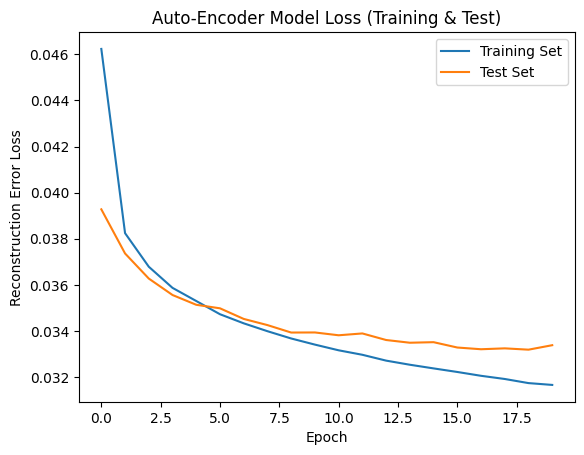

Overall Correlation: 0.5565
dims=5.000000
cuda:0
Number of parameters: 1191174


AutoEncoder Parameters,▁
Epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Latent Code Dims,▁
Overall Correlation,▁
Test Loss,█▆▅▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁
Train Loss,█▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
AutoEncoder Parameters,1140996
Epoch,20
Latent Code Dims,3
Overall Correlation,0.55651
Test Loss,0.03338


AutoEncoder Parameters: 1191174
Epoch [1 / 20] average reconstruction error on Train dataset: 0.038020
Epoch [1 / 20] average reconstruction error on Test dataset: 0.030288
Epoch [2 / 20] average reconstruction error on Train dataset: 0.028983
Epoch [2 / 20] average reconstruction error on Test dataset: 0.028017
Epoch [3 / 20] average reconstruction error on Train dataset: 0.027421
Epoch [3 / 20] average reconstruction error on Test dataset: 0.026981
Epoch [4 / 20] average reconstruction error on Train dataset: 0.026525
Epoch [4 / 20] average reconstruction error on Test dataset: 0.026282
Epoch [5 / 20] average reconstruction error on Train dataset: 0.025818
Epoch [5 / 20] average reconstruction error on Test dataset: 0.025706
Epoch [6 / 20] average reconstruction error on Train dataset: 0.025298
Epoch [6 / 20] average reconstruction error on Test dataset: 0.025117
Epoch [7 / 20] average reconstruction error on Train dataset: 0.024876
Epoch [7 / 20] average reconstruction error on Test

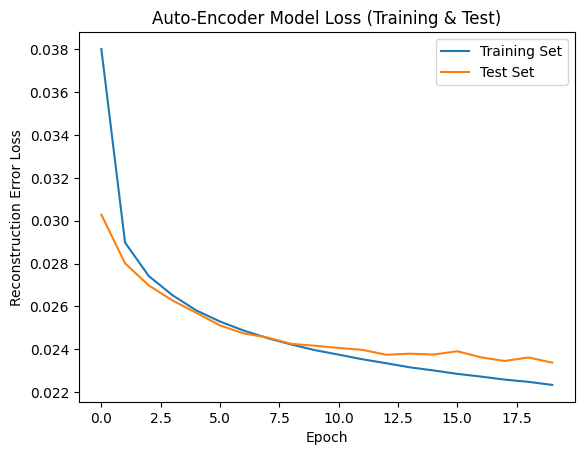

Overall Correlation: 0.2597
dims=8.000000
cuda:0
Number of parameters: 1266441


AutoEncoder Parameters,▁
Epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Latent Code Dims,▁
Overall Correlation,▁
Test Loss,█▆▅▄▃▃▂▂▂▂▂▂▁▁▁▂▁▁▁▁
Train Loss,█▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
AutoEncoder Parameters,1191174
Epoch,20
Latent Code Dims,5
Overall Correlation,0.25967
Test Loss,0.02338


AutoEncoder Parameters: 1266441
Epoch [1 / 20] average reconstruction error on Train dataset: 0.029187
Epoch [1 / 20] average reconstruction error on Test dataset: 0.020499
Epoch [2 / 20] average reconstruction error on Train dataset: 0.019698
Epoch [2 / 20] average reconstruction error on Test dataset: 0.018414
Epoch [3 / 20] average reconstruction error on Train dataset: 0.018131
Epoch [3 / 20] average reconstruction error on Test dataset: 0.017260
Epoch [4 / 20] average reconstruction error on Train dataset: 0.017271
Epoch [4 / 20] average reconstruction error on Test dataset: 0.016651
Epoch [5 / 20] average reconstruction error on Train dataset: 0.016680
Epoch [5 / 20] average reconstruction error on Test dataset: 0.016342
Epoch [6 / 20] average reconstruction error on Train dataset: 0.016205
Epoch [6 / 20] average reconstruction error on Test dataset: 0.016099
Epoch [7 / 20] average reconstruction error on Train dataset: 0.015858
Epoch [7 / 20] average reconstruction error on Test

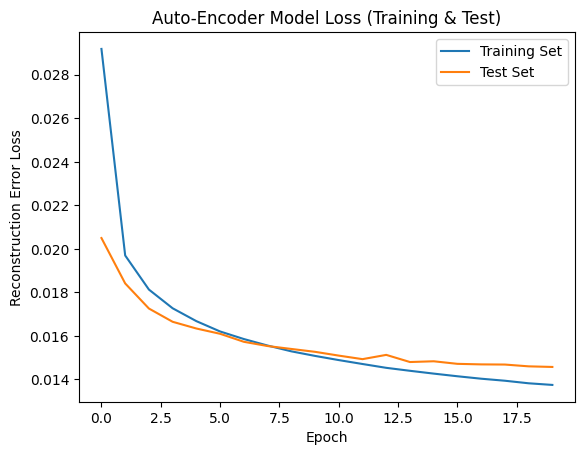

Overall Correlation: 0.1470
dims=10.000000
cuda:0
Number of parameters: 1316619


AutoEncoder Parameters,▁
Epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Latent Code Dims,▁
Overall Correlation,▁
Test Loss,█▆▄▃▃▃▂▂▂▂▂▁▂▁▁▁▁▁▁▁
Train Loss,█▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
AutoEncoder Parameters,1266441
Epoch,20
Latent Code Dims,8
Overall Correlation,0.14696
Test Loss,0.01458


AutoEncoder Parameters: 1316619
Epoch [1 / 20] average reconstruction error on Train dataset: 0.053287
Epoch [1 / 20] average reconstruction error on Test dataset: 0.020695
Epoch [2 / 20] average reconstruction error on Train dataset: 0.018875
Epoch [2 / 20] average reconstruction error on Test dataset: 0.017237
Epoch [3 / 20] average reconstruction error on Train dataset: 0.016563
Epoch [3 / 20] average reconstruction error on Test dataset: 0.015809
Epoch [4 / 20] average reconstruction error on Train dataset: 0.015294
Epoch [4 / 20] average reconstruction error on Test dataset: 0.014842
Epoch [5 / 20] average reconstruction error on Train dataset: 0.014495
Epoch [5 / 20] average reconstruction error on Test dataset: 0.014026
Epoch [6 / 20] average reconstruction error on Train dataset: 0.013891
Epoch [6 / 20] average reconstruction error on Test dataset: 0.013577
Epoch [7 / 20] average reconstruction error on Train dataset: 0.013398
Epoch [7 / 20] average reconstruction error on Test

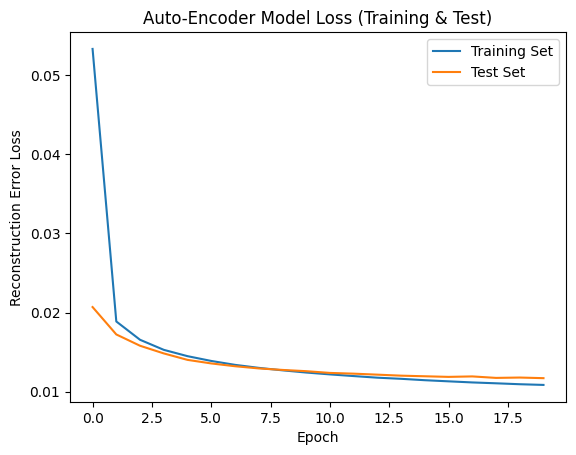

Overall Correlation: 0.1142
dims=15.000000
cuda:0
Number of parameters: 1442064


AutoEncoder Parameters,▁
Epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Latent Code Dims,▁
Overall Correlation,▁
Test Loss,█▅▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
Train Loss,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
AutoEncoder Parameters,1316619
Epoch,20
Latent Code Dims,10
Overall Correlation,0.11424
Test Loss,0.01172


AutoEncoder Parameters: 1442064
Epoch [1 / 20] average reconstruction error on Train dataset: 0.025905
Epoch [1 / 20] average reconstruction error on Test dataset: 0.012186
Epoch [2 / 20] average reconstruction error on Train dataset: 0.011327
Epoch [2 / 20] average reconstruction error on Test dataset: 0.010312
Epoch [3 / 20] average reconstruction error on Train dataset: 0.009869
Epoch [3 / 20] average reconstruction error on Test dataset: 0.009564
Epoch [4 / 20] average reconstruction error on Train dataset: 0.009130
Epoch [4 / 20] average reconstruction error on Test dataset: 0.008896
Epoch [5 / 20] average reconstruction error on Train dataset: 0.008643
Epoch [5 / 20] average reconstruction error on Test dataset: 0.008563
Epoch [6 / 20] average reconstruction error on Train dataset: 0.008280
Epoch [6 / 20] average reconstruction error on Test dataset: 0.008294
Epoch [7 / 20] average reconstruction error on Train dataset: 0.007995
Epoch [7 / 20] average reconstruction error on Test

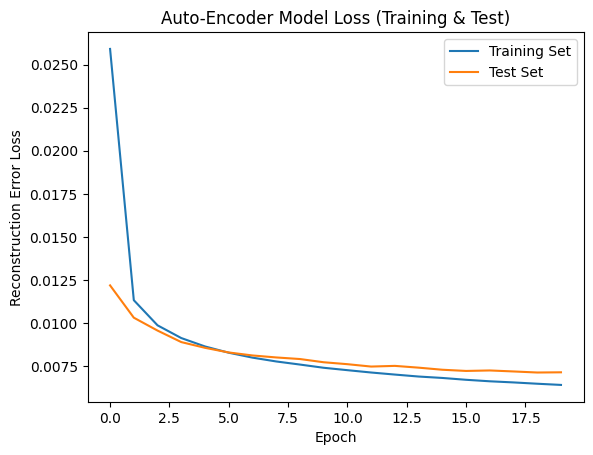

Overall Correlation: 0.0728
dims=20.000000
cuda:0
Number of parameters: 1567509


AutoEncoder Parameters,▁
Epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Latent Code Dims,▁
Overall Correlation,▁
Test Loss,█▅▄▃▃▃▂▂▂▂▂▁▂▁▁▁▁▁▁▁
Train Loss,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
AutoEncoder Parameters,1442064
Epoch,20
Latent Code Dims,15
Overall Correlation,0.07276
Test Loss,0.00714


AutoEncoder Parameters: 1567509
Epoch [1 / 20] average reconstruction error on Train dataset: 0.021243
Epoch [1 / 20] average reconstruction error on Test dataset: 0.009275
Epoch [2 / 20] average reconstruction error on Train dataset: 0.008480
Epoch [2 / 20] average reconstruction error on Test dataset: 0.007843
Epoch [3 / 20] average reconstruction error on Train dataset: 0.007416
Epoch [3 / 20] average reconstruction error on Test dataset: 0.007073
Epoch [4 / 20] average reconstruction error on Train dataset: 0.006834
Epoch [4 / 20] average reconstruction error on Test dataset: 0.006649
Epoch [5 / 20] average reconstruction error on Train dataset: 0.006444
Epoch [5 / 20] average reconstruction error on Test dataset: 0.006433
Epoch [6 / 20] average reconstruction error on Train dataset: 0.006184
Epoch [6 / 20] average reconstruction error on Test dataset: 0.006210
Epoch [7 / 20] average reconstruction error on Train dataset: 0.005965
Epoch [7 / 20] average reconstruction error on Test

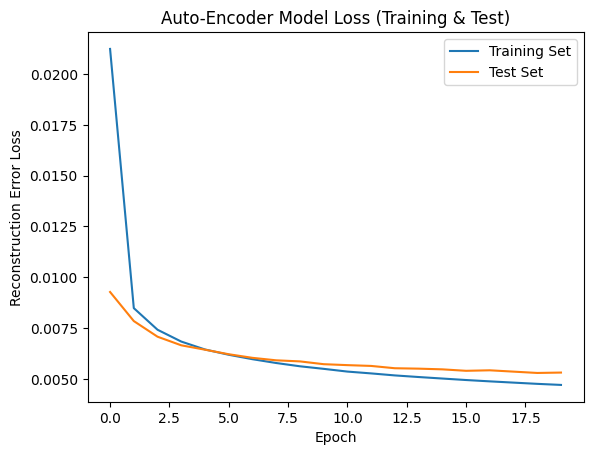

Overall Correlation: 0.0533
dims=30.000000
cuda:0
Number of parameters: 1818399


AutoEncoder Parameters,▁
Epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Latent Code Dims,▁
Overall Correlation,▁
Test Loss,█▅▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁
Train Loss,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
AutoEncoder Parameters,1567509
Epoch,20
Latent Code Dims,20
Overall Correlation,0.05327
Test Loss,0.00531


AutoEncoder Parameters: 1818399
Epoch [1 / 20] average reconstruction error on Train dataset: 0.020780
Epoch [1 / 20] average reconstruction error on Test dataset: 0.006549
Epoch [2 / 20] average reconstruction error on Train dataset: 0.005858
Epoch [2 / 20] average reconstruction error on Test dataset: 0.005291
Epoch [3 / 20] average reconstruction error on Train dataset: 0.004977
Epoch [3 / 20] average reconstruction error on Test dataset: 0.004666
Epoch [4 / 20] average reconstruction error on Train dataset: 0.004552
Epoch [4 / 20] average reconstruction error on Test dataset: 0.004423
Epoch [5 / 20] average reconstruction error on Train dataset: 0.004276
Epoch [5 / 20] average reconstruction error on Test dataset: 0.004187
Epoch [6 / 20] average reconstruction error on Train dataset: 0.004079
Epoch [6 / 20] average reconstruction error on Test dataset: 0.004079
Epoch [7 / 20] average reconstruction error on Train dataset: 0.003931
Epoch [7 / 20] average reconstruction error on Test

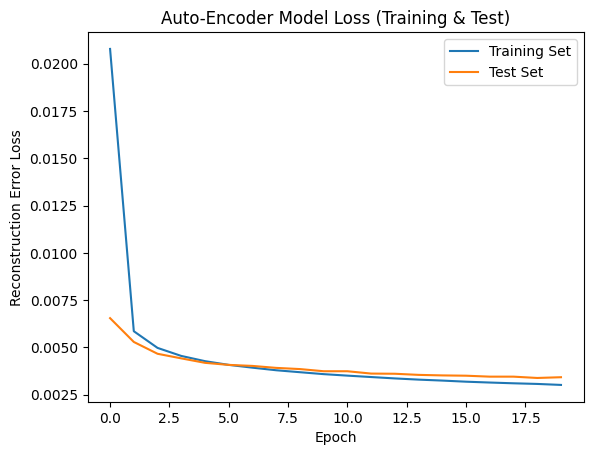

Overall Correlation: 0.0348


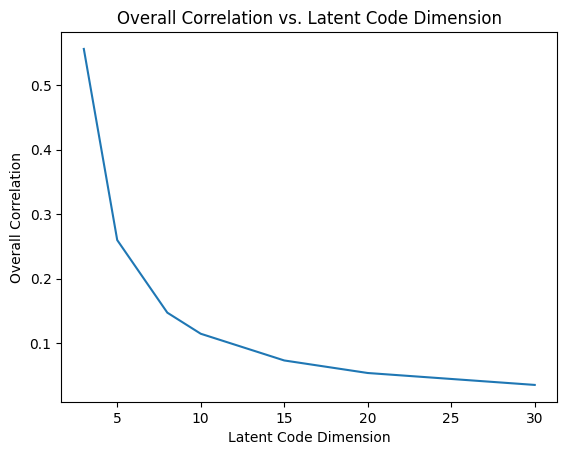

In [ ]:
# Set the desired number of dimensions in the latent space
dims = [3, 5 ,8, 10, 15, 20, 30]
plot_correlation_graph(dims)

dim=3.000000
cuda:0
Number of parameters: 1140996


AutoEncoder Parameters,▁
Autoencoder Parameters,▁
Epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Test Accuracy Full Network,▁▂▃▃▄▅▅▆▇███████████
Train Loss Full Network,█▇▆▆▅▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁
dims,▁
AutoEncoder Parameters,1140996
Autoencoder Parameters,915944
Epoch,20
Test Accuracy Full Network,73.9
Train Loss Full Network,0.0035


AutoEncoder Parameters: 1140996
Epoch [1 / 20] average reconstruction error on Train dataset: 0.047537
Epoch [1 / 20] average reconstruction error on Test dataset: 0.039846
Epoch [2 / 20] average reconstruction error on Train dataset: 0.039220
Epoch [2 / 20] average reconstruction error on Test dataset: 0.037883
Epoch [3 / 20] average reconstruction error on Train dataset: 0.037539
Epoch [3 / 20] average reconstruction error on Test dataset: 0.036795
Epoch [4 / 20] average reconstruction error on Train dataset: 0.036470
Epoch [4 / 20] average reconstruction error on Test dataset: 0.035846
Epoch [5 / 20] average reconstruction error on Train dataset: 0.035712
Epoch [5 / 20] average reconstruction error on Test dataset: 0.035167
Epoch [6 / 20] average reconstruction error on Train dataset: 0.035156
Epoch [6 / 20] average reconstruction error on Test dataset: 0.034834
Epoch [7 / 20] average reconstruction error on Train dataset: 0.034679
Epoch [7 / 20] average reconstruction error on Test

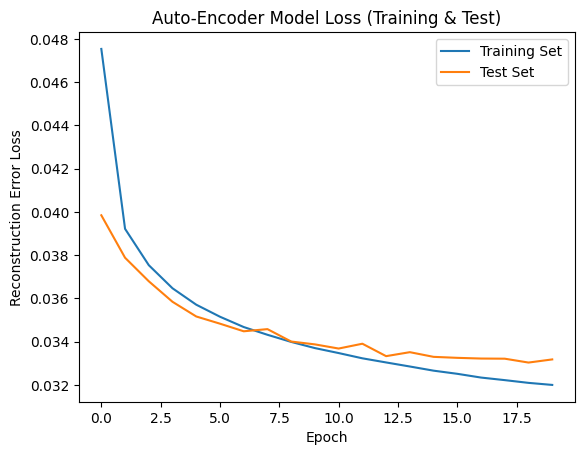

Overall Correlation: 0.5687
dim=5.000000
cuda:0
Number of parameters: 1191174


AutoEncoder Parameters,▁█
Epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Latent Code Dims,▁
Overall Correlation,▁
Test Loss,█▆▅▄▃▃▂▃▂▂▂▂▁▁▁▁▁▁▁▁
Train Loss,█▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
dims,▁
AutoEncoder Parameters,1191174
Epoch,20
Latent Code Dims,30
Overall Correlation,0.56871


AutoEncoder Parameters: 1191174
Epoch [1 / 20] average reconstruction error on Train dataset: 0.037866
Epoch [1 / 20] average reconstruction error on Test dataset: 0.029719
Epoch [2 / 20] average reconstruction error on Train dataset: 0.028624
Epoch [2 / 20] average reconstruction error on Test dataset: 0.027494
Epoch [3 / 20] average reconstruction error on Train dataset: 0.027072
Epoch [3 / 20] average reconstruction error on Test dataset: 0.026345
Epoch [4 / 20] average reconstruction error on Train dataset: 0.026157
Epoch [4 / 20] average reconstruction error on Test dataset: 0.025794
Epoch [5 / 20] average reconstruction error on Train dataset: 0.025502
Epoch [5 / 20] average reconstruction error on Test dataset: 0.025317
Epoch [6 / 20] average reconstruction error on Train dataset: 0.025003
Epoch [6 / 20] average reconstruction error on Test dataset: 0.024870
Epoch [7 / 20] average reconstruction error on Train dataset: 0.024620
Epoch [7 / 20] average reconstruction error on Test

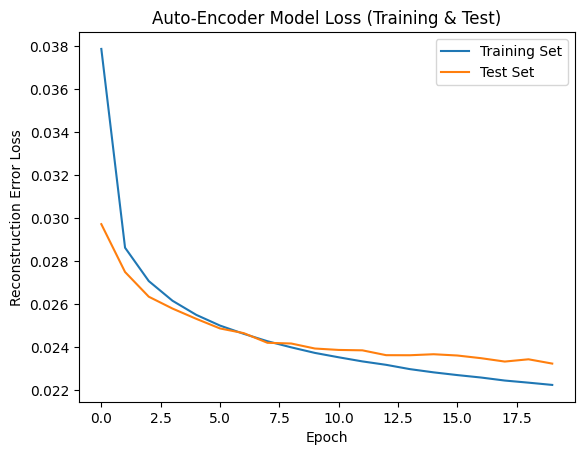

Overall Correlation: 0.2612
dim=10.000000
cuda:0
Number of parameters: 1316619


AutoEncoder Parameters,▁█
Epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Latent Code Dims,▁
Overall Correlation,▁
Test Loss,█▆▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁
Train Loss,█▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
dims,▁
AutoEncoder Parameters,1316619
Epoch,20
Latent Code Dims,30
Overall Correlation,0.26119


AutoEncoder Parameters: 1316619
Epoch [1 / 20] average reconstruction error on Train dataset: 0.033572
Epoch [1 / 20] average reconstruction error on Test dataset: 0.018731
Epoch [2 / 20] average reconstruction error on Train dataset: 0.017577
Epoch [2 / 20] average reconstruction error on Test dataset: 0.015962
Epoch [3 / 20] average reconstruction error on Train dataset: 0.015518
Epoch [3 / 20] average reconstruction error on Test dataset: 0.014603
Epoch [4 / 20] average reconstruction error on Train dataset: 0.014458
Epoch [4 / 20] average reconstruction error on Test dataset: 0.013979
Epoch [5 / 20] average reconstruction error on Train dataset: 0.013759
Epoch [5 / 20] average reconstruction error on Test dataset: 0.013400
Epoch [6 / 20] average reconstruction error on Train dataset: 0.013268
Epoch [6 / 20] average reconstruction error on Test dataset: 0.013020
Epoch [7 / 20] average reconstruction error on Train dataset: 0.012866
Epoch [7 / 20] average reconstruction error on Test

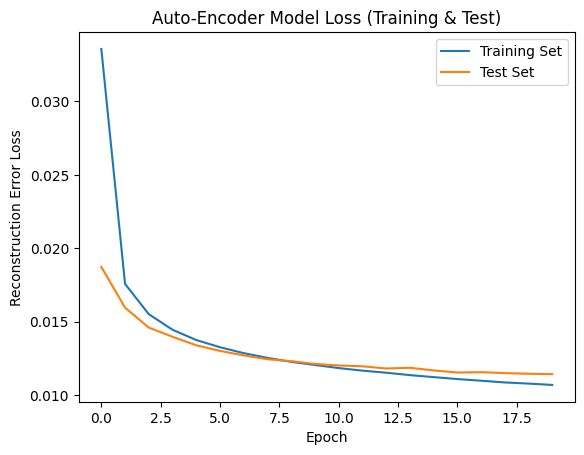

Overall Correlation: 0.1137
dim=15.000000
cuda:0
Number of parameters: 1442064


AutoEncoder Parameters,▁█
Epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Latent Code Dims,▁
Overall Correlation,▁
Test Loss,█▅▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁
Train Loss,█▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
dims,▁
AutoEncoder Parameters,1442064
Epoch,20
Latent Code Dims,30
Overall Correlation,0.11375


AutoEncoder Parameters: 1442064
Epoch [1 / 20] average reconstruction error on Train dataset: 0.024204
Epoch [1 / 20] average reconstruction error on Test dataset: 0.012322
Epoch [2 / 20] average reconstruction error on Train dataset: 0.011457
Epoch [2 / 20] average reconstruction error on Test dataset: 0.010649
Epoch [3 / 20] average reconstruction error on Train dataset: 0.009989
Epoch [3 / 20] average reconstruction error on Test dataset: 0.009572
Epoch [4 / 20] average reconstruction error on Train dataset: 0.009226
Epoch [4 / 20] average reconstruction error on Test dataset: 0.008960
Epoch [5 / 20] average reconstruction error on Train dataset: 0.008721
Epoch [5 / 20] average reconstruction error on Test dataset: 0.008635
Epoch [6 / 20] average reconstruction error on Train dataset: 0.008336
Epoch [6 / 20] average reconstruction error on Test dataset: 0.008381
Epoch [7 / 20] average reconstruction error on Train dataset: 0.008046
Epoch [7 / 20] average reconstruction error on Test

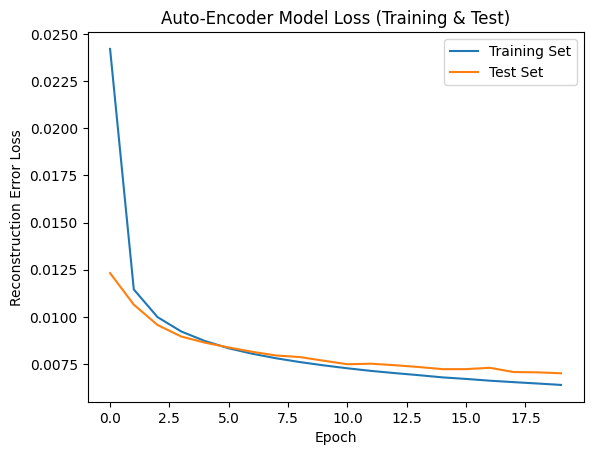

Overall Correlation: 0.0727
dim=20.000000
cuda:0
Number of parameters: 1567509


AutoEncoder Parameters,▁█
Epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Latent Code Dims,▁
Overall Correlation,▁
Test Loss,█▆▄▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁
Train Loss,█▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
dims,▁
AutoEncoder Parameters,1567509
Epoch,20
Latent Code Dims,30
Overall Correlation,0.07266


AutoEncoder Parameters: 1567509
Epoch [1 / 20] average reconstruction error on Train dataset: 0.022774
Epoch [1 / 20] average reconstruction error on Test dataset: 0.009714
Epoch [2 / 20] average reconstruction error on Train dataset: 0.008915
Epoch [2 / 20] average reconstruction error on Test dataset: 0.008003
Epoch [3 / 20] average reconstruction error on Train dataset: 0.007665
Epoch [3 / 20] average reconstruction error on Test dataset: 0.007243
Epoch [4 / 20] average reconstruction error on Train dataset: 0.007042
Epoch [4 / 20] average reconstruction error on Test dataset: 0.006841
Epoch [5 / 20] average reconstruction error on Train dataset: 0.006636
Epoch [5 / 20] average reconstruction error on Test dataset: 0.006572
Epoch [6 / 20] average reconstruction error on Train dataset: 0.006348
Epoch [6 / 20] average reconstruction error on Test dataset: 0.006324
Epoch [7 / 20] average reconstruction error on Train dataset: 0.006104
Epoch [7 / 20] average reconstruction error on Test

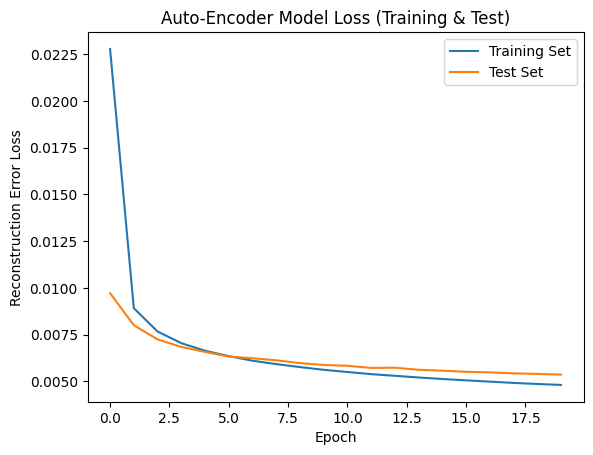

Overall Correlation: 0.0533
dim=30.000000
cuda:0
Number of parameters: 1818399


AutoEncoder Parameters,▁█
Epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Latent Code Dims,▁
Overall Correlation,▁
Test Loss,█▅▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁
Train Loss,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
dims,▁
AutoEncoder Parameters,1818399
Epoch,20
Latent Code Dims,30
Overall Correlation,0.05334


AutoEncoder Parameters: 1818399
Epoch [1 / 20] average reconstruction error on Train dataset: 0.033111
Epoch [1 / 20] average reconstruction error on Test dataset: 0.008013
Epoch [2 / 20] average reconstruction error on Train dataset: 0.006829
Epoch [2 / 20] average reconstruction error on Test dataset: 0.005829
Epoch [3 / 20] average reconstruction error on Train dataset: 0.005571
Epoch [3 / 20] average reconstruction error on Test dataset: 0.005279
Epoch [4 / 20] average reconstruction error on Train dataset: 0.005022
Epoch [4 / 20] average reconstruction error on Test dataset: 0.004857
Epoch [5 / 20] average reconstruction error on Train dataset: 0.004692
Epoch [5 / 20] average reconstruction error on Test dataset: 0.004695
Epoch [6 / 20] average reconstruction error on Train dataset: 0.004444
Epoch [6 / 20] average reconstruction error on Test dataset: 0.004416
Epoch [7 / 20] average reconstruction error on Train dataset: 0.004249
Epoch [7 / 20] average reconstruction error on Test

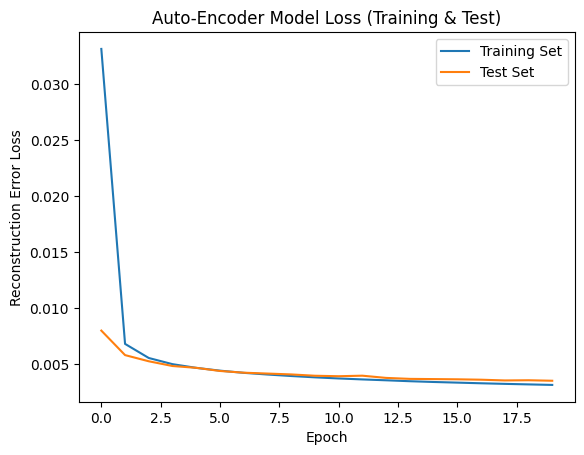

Overall Correlation: 0.0347


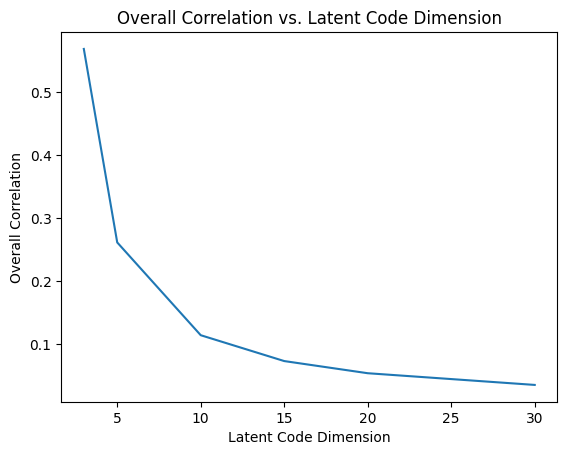

In [ ]:
# Set the desired number of dimensions in the latent space
dims = [3, 5, 10, 15, 20, 30]
plot_correlation_graph(dims)

In [109]:
import torch
import torch.nn as nn
import torch.nn.functional as F

output_dims = 10
latent_dims = 15
num_epochs = 120

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 32)
        self.fc3 = nn.Linear(32, output_size)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)
        return x

mlp1 = MLP(input_size=latent_dims, hidden_size=64, output_size=output_dims)
mlp1 = mlp1.to(device)

mlp2 = MLP(input_size=latent_dims, hidden_size=64, output_size=output_dims)
mlp2 = mlp2.to(device)

# Print number of parameters in the encoder
num_params = sum(p.numel() for p in autoencoder.encoder.parameters() if p.requires_grad)
print('Number of parameters in Encoder: %d' % num_params)
wandb.log({"Autoencoder Parameters": num_params})

print(device)

num_params = sum(p.numel() for p in mlp1.parameters() if p.requires_grad)
print('Number of parameters in MLP: %d' % num_params)
wandb.log({"MLP Parameters": num_params})

Number of parameters in Encoder: 714895
cuda:0
Number of parameters in MLP: 3434


In [110]:
import random
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

img_transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = MNIST(root='./data/MNIST', download=True, train=True, transform=img_transform)
train_size = len(train_dataset)
train_indices = random.sample(range(train_size), 100)  # select a random subset of 100 samples
train_subset = torch.utils.data.Subset(train_dataset, train_indices)
train_dataloader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)

test_dataset = MNIST(root='./data/MNIST', download=True, train=False, transform=img_transform)
test_size = len(test_dataset)
test_indices = random.sample(range(test_size), 1000)  # select a random subset of 1000 samples
test_subset = torch.utils.data.Subset(test_dataset, test_indices)
test_dataloader = DataLoader(test_subset, batch_size=batch_size, shuffle=True)

In [111]:
def train_encoder1(model, train_dataloader, optimizer, num_epochs, device):
    model.train()
    train_loss_avg = []

    for epoch in range(num_epochs):
        train_loss_avg.append(0)
        num_batches = 0

        for image_batch, target in train_dataloader:  # Update here to unpack target from dataloader

            image_batch = image_batch.to(device)
            target = target.to(device)

            # encoder output
            latent_code = model[0](image_batch)

            # MLP output
            output = model[1](latent_code)

            # compute the reconstruction error
            loss = F.cross_entropy(output, target)  # Update here to pass target to loss function

            # backpropagation
            optimizer.zero_grad()
            loss.backward()

            # one step of the optimizer (using the gradients from backpropagation)
            optimizer.step()

            train_loss_avg[-1] += loss.item()
            num_batches += 1

        train_loss_avg[-1] /= num_batches
        print('Epoch [%d / %d] average loss: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))
        wandb.log({"Train Loss": train_loss_avg[-1], "Epoch": epoch})

    return train_loss_avg

def train_encoder(autoencoder, train_dataloader, test_dataloader, optimizer, num_epochs, device, transfer_learning=True):
    autoencoder.train()
    train_loss_avg = []
    test_loss_avg = []
    accuracy_vals = []
    wandb.init(project="ex2-amithalbreich-new",
    config={
      "learning_rate": 0.003,
      "architecture": "CNN",
      "dataset": "MNIST",
      "epochs": 40,
      }
    )

    # Print number of parameters in the encoder
    num_params = sum(p.numel() for p in autoencoder.parameters() if p.requires_grad)
    print('Number of parameters in Encoder: %d' % num_params)
    wandb.log({"Autoencoder Parameters": num_params})

    # log dims
    wandb.log({"dims": latent_dims})


    for epoch in range(num_epochs):
        autoencoder.train()
        train_loss_avg.append(0)
        test_loss_avg.append(0)
        num_batches_train = 0
        num_batches_test = 0
        correct = 0
        total = 0

        for image_batch, labels in train_dataloader:  # Update here to unpack target from dataloader

            image_batch = image_batch.to(device)
            labels = labels.to(device)

            # encoder output
            latent_code = autoencoder[0](image_batch)

             # MLP output
            outputs = autoencoder[1](latent_code)


            # compute the reconstruction error
            # loss = F.cross_entropy(outputs, labels)  # Update here to pass labels to loss function
            loss = nn.CrossEntropyLoss()(outputs, labels)  # Update here to pass labels to loss function


            # backpropagation
            optimizer.zero_grad()
            loss.backward()

            # one step of the optimizer (using the gradients from backpropagation)
            optimizer.step()

            train_loss_avg[-1] += loss.item()
            num_batches_train += 1

        train_loss_avg[-1] /= num_batches_train
        autoencoder.eval()
        for image_batch, labels in test_dataloader:
            with torch.no_grad():
                image_batch = image_batch.to(device)
                labels = labels.to(device)

                # encoder output
                latent_code = autoencoder[0](image_batch)

                # MLP output
                outputs = autoencoder[1](latent_code)

                 # Get predicted labels
                _, predicted = torch.max(outputs, dim=1)

                # Update total and correct predictions
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
                # compute the reconstruction error
                # loss = F.cross_entropy(outputs, labels)  # Update here to pass target to loss function
                loss = nn.CrossEntropyLoss()(outputs, labels)  # Update here to pass target to loss function


                test_loss_avg[-1] += loss.item()
                num_batches_test += 1
        test_loss_avg[-1] /= num_batches_test
        total_accuracy = (correct / total) * 100
        accuracy_vals.append(total_accuracy)
        print('Epoch [%d / %d] average reconstruction error on Train dataset: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))
        print('Accuracy on test dataloader: {:.2f}%'.format(accuracy_vals[-1]))
        print('Epoch [%d / %d] average reconstruction error on Test dataset: %f' % (epoch+1, num_epochs, test_loss_avg[-1]))
        if transfer_learning:
            wandb.log({"Test Accuracy Transfer Learning" : accuracy_vals[-1], "Train Loss Transfer Learining": train_loss_avg[-1],  "Test Loss Transfer Learining": test_loss_avg[-1], "Epoch num": epoch + 1})
        else:
            wandb.log({"Test Accuracy Full Network" : accuracy_vals[-1], "Train Loss Full Network": train_loss_avg[-1], "Test Loss Full Network": test_loss_avg[-1], "Epoch num": epoch + 1})
    return train_loss_avg, test_loss_avg, accuracy_vals

In [112]:
import copy
# Combine Encoder and MLP into a single model
without_encoder = autoencoder.encoder
with_mlp = nn.Sequential(without_encoder, mlp1)
with_mlp = with_mlp.to(device)

# Set up optimizer
optimizer1 = AdamW(mlp1.parameters(), lr=learning_rate, weight_decay=1e-5)

# # Train the combined model with only MLP optimizer
train_loss_just_mlp, test_loss_just_mlp, acc_vals_just_mlp = train_encoder(with_mlp, train_dataloader, test_dataloader, optimizer1, num_epochs, device, transfer_learning=True)

# Combine Encoder and MLP into a single model
with_encoder = autoencoder.encoder
with_mlp_encoder = nn.Sequential(with_encoder, mlp2)
with_mlp_encoder = with_mlp_encoder.to(device)

# Set up optimizer
optimizer2 = AdamW(with_mlp_encoder.parameters(), lr=learning_rate, weight_decay=1e-5)

# Train the combined model with MLP and Trained AE combined
train_loss_full_network, test_loss_full_network, acc_vals_full_network = train_encoder(with_mlp_encoder, train_dataloader, test_dataloader, optimizer2, num_epochs, device, transfer_learning=False)

AutoEncoder Parameters,▁
Autoencoder Parameters,▁▁
Epoch,▁▃▅▆█
MLP Parameters,▁▁
Test Loss,█▄▃▂▁
Train Loss,█▂▁▁▁
AutoEncoder Parameters,1442064
Autoencoder Parameters,714895
Epoch,5
MLP Parameters,3434
Test Loss,0.00868


Number of parameters in Encoder: 718329
Epoch [1 / 120] average reconstruction error on Train dataset: 2.284536
Accuracy on test dataloader: 9.70%
Epoch [1 / 120] average reconstruction error on Test dataset: 2.314028
Epoch [2 / 120] average reconstruction error on Train dataset: 2.268235
Accuracy on test dataloader: 13.00%
Epoch [2 / 120] average reconstruction error on Test dataset: 2.304917
Epoch [3 / 120] average reconstruction error on Train dataset: 2.252433
Accuracy on test dataloader: 15.70%
Epoch [3 / 120] average reconstruction error on Test dataset: 2.296754
Epoch [4 / 120] average reconstruction error on Train dataset: 2.236858
Accuracy on test dataloader: 18.30%
Epoch [4 / 120] average reconstruction error on Test dataset: 2.289034
Epoch [5 / 120] average reconstruction error on Train dataset: 2.221536
Accuracy on test dataloader: 20.50%
Epoch [5 / 120] average reconstruction error on Test dataset: 2.280368
Epoch [6 / 120] average reconstruction error on Train dataset: 2.2

Autoencoder Parameters,▁
Epoch num,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Test Accuracy Transfer Learning,▁▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██████████
Test Loss Transfer Learining,█████▇▇▇▇▇▇▇▆▆▆▆▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁
Train Loss Transfer Learining,████▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
dims,▁
Autoencoder Parameters,718329
Epoch num,120
Test Accuracy Transfer Learning,77.8
Test Loss Transfer Learining,0.70003
Train Loss Transfer Learining,0.16464


Number of parameters in Encoder: 718329
Epoch [1 / 120] average reconstruction error on Train dataset: 2.255644
Accuracy on test dataloader: 17.80%
Epoch [1 / 120] average reconstruction error on Test dataset: 2.259778
Epoch [2 / 120] average reconstruction error on Train dataset: 2.196058
Accuracy on test dataloader: 19.20%
Epoch [2 / 120] average reconstruction error on Test dataset: 2.227860
Epoch [3 / 120] average reconstruction error on Train dataset: 2.130112
Accuracy on test dataloader: 21.50%
Epoch [3 / 120] average reconstruction error on Test dataset: 2.188015
Epoch [4 / 120] average reconstruction error on Train dataset: 2.049847
Accuracy on test dataloader: 23.30%
Epoch [4 / 120] average reconstruction error on Test dataset: 2.140716
Epoch [5 / 120] average reconstruction error on Train dataset: 1.955675
Accuracy on test dataloader: 24.20%
Epoch [5 / 120] average reconstruction error on Test dataset: 2.092829
Epoch [6 / 120] average reconstruction error on Train dataset: 1.

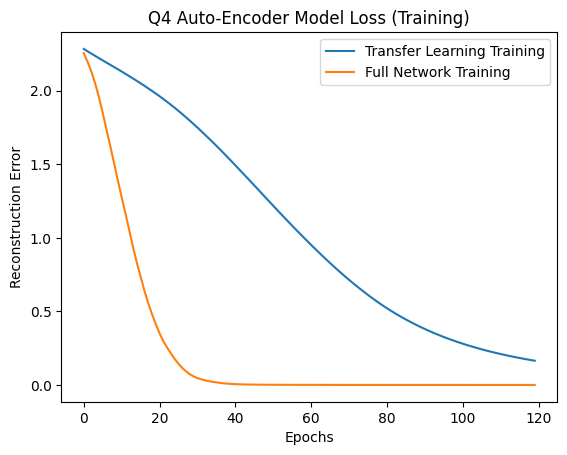

In [113]:

import matplotlib.pyplot as plt
plt.ion()

fig = plt.figure()
plt.title('Q4 Auto-Encoder Model Loss (Training)')
plt.plot(train_loss_just_mlp, label='Transfer Learning Network')
plt.plot(train_loss_full_network, label='Full Network Training')
plt.legend(['Transfer Learning Training', 'Full Network Training'], loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Reconstruction Error')
plt.show()

[17.8, 19.2, 21.5, 23.3, 24.2, 24.2, 25.2, 27.3, 30.7, 34.5, 38.1, 40.300000000000004, 42.1, 46.300000000000004, 52.300000000000004, 55.60000000000001, 57.9, 58.8, 59.8, 60.8, 62.2, 62.9, 64.0, 64.9, 65.3, 66.5, 67.5, 68.10000000000001, 68.5, 70.0, 70.7, 71.2, 71.7, 71.8, 71.5, 71.7, 71.89999999999999, 72.2, 72.2, 72.3, 72.39999999999999, 72.6, 72.8, 73.2, 73.7, 73.4, 72.8, 72.7, 72.7, 72.89999999999999, 72.7, 72.8, 73.0, 73.3, 73.3, 73.3, 73.5, 73.3, 73.3, 73.3, 73.3, 73.2, 73.0, 72.89999999999999, 73.0, 73.0, 72.89999999999999, 72.89999999999999, 72.89999999999999, 72.8, 72.8, 72.7, 72.8, 72.8, 72.8, 72.7, 72.89999999999999, 73.1, 73.0, 72.89999999999999, 72.89999999999999, 72.89999999999999, 72.8, 72.7, 72.89999999999999, 73.0, 73.1, 73.0, 73.0, 73.1, 73.2, 73.1, 73.1, 73.2, 73.2, 73.1, 73.1, 73.1, 73.3, 73.4, 73.4, 73.4, 73.4, 73.3, 73.3, 73.4, 73.4, 73.5, 73.5, 73.5, 73.5, 73.6, 73.6, 73.7, 73.7, 73.8, 73.8, 73.8, 73.8, 73.8]
[9.700000000000001, 13.0, 15.7, 18.3, 20.5, 22.6, 22.90

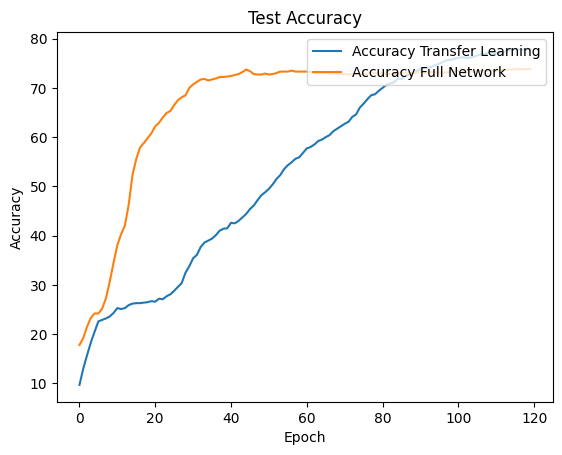

In [114]:
# Plot the training and validation loss
fig = plt.figure()
plt.ion()
print(acc_vals_full_network)
print(acc_vals_just_mlp)
plt.plot(acc_vals_just_mlp, label='Accuracy Transfer Learning')
plt.plot(acc_vals_full_network, label='Accuracy Full Network')
plt.title('Test Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Accuracy Transfer Learning', 'Accuracy Full Network'], loc='upper right')
plt.show()